# Composite States

The [CompositeState](../_autosummary/navlie.composite.CompositeState.rst) is a class that allows you to arbitarily combine multiple states, potentially of different types, into a new state that can be used with the navlie framework.

Let's consider the previous example where we used the following $SE(2)$ pose transformation matrix to represent the state:

$$ 
\mathbf{T} = \begin{bmatrix} \mathbf{C}_{ab} & \mathbf{r}_a \\ \mathbf{0} & 1 \end{bmatrix} \in SE(2).
$$

Suppose we now also want to estimate a wheel odometry bias $\mathbf{b} \in \mathbb{R}^2$ in addition to the robot's pose. Our state is now 

$$
\mathbf{x} = (\mathbf{T}, \mathbf{b}) \in SE(2) \times \mathbb{R}^2.
$$

This can be implemented easily using the [CompositeState](../_autosummary/navlie.composite.CompositeState.rst) class in one of two ways: either directly or by inheritance. We'll show the former approach first.

In [48]:
import navlie as nav 
import numpy as np

# Define the pose and bias as their own states
T = nav.lib.SE2State(value = [0.1, 2.0, 3.0], stamp = 0.0, state_id="pose")
b = nav.lib.VectorState(value = [0.1, 2.0], stamp = 0.0, state_id="bias")

# Combine into a composite state, and its ready to use!
x = nav.CompositeState([T, b], stamp=0.0)

print(x)

CompositeState(stamp=0.0, state_id=None) with substates:
    SE2State(stamp=0.0, state_id=pose, direction=right)
        [[ 0.99500417 -0.09983342  1.84679329]
         [ 0.09983342  0.99500417  3.09491919]
         [ 0.          0.          1.        ]]
    VectorState(stamp=0.0, dof=2, state_id=bias)
        [0.1 2. ]


The ``CompositeState`` class is a subclass of the ``State`` class, but who's ``value`` is a list of states, referred to as the *substates*. A convenience of this class is that the composite state's ``plus``, ``minus``, and ``copy`` methods have already been implemented for you based on the implementations in the substates. Note that the order in which the states are listed is important, and will correspond to the order of the components in the vectors involved in the ``plus`` and ``minus`` operations. This can be demonstrated with the following example.

In [49]:
# plus() and minus() have been defined for you. Here, the first three elements
# of the vector to be added correspond to the pose (since it has 3 DOF), and the
# last two to the bias.
x_temp = x.plus(np.array([1,2,3,4,5]))
print("\nResult after plus():")
print(x_temp)

dx = x_temp.minus(x)
print("\nResult after minus():")
print(dx)


Result after plus():
CompositeState(stamp=0.0, state_id=None) with substates:
    SE2State(stamp=0.0, state_id=pose, direction=right)
        [[ 0.45359612 -0.89120736  1.80531705]
         [ 0.89120736  0.45359612  6.55185711]
         [ 0.          0.          1.        ]]
    VectorState(stamp=0.0, dof=2, state_id=bias)
        [4.1 7. ]

Result after minus():
[[1.]
 [2.]
 [3.]
 [4.]
 [5.]]


Next, we must write a process model that works with this state. We'll use the same process model as before, but now we'll also include the wheel odometry bias in the state. The bias process model will be modelled as a random walk of the form 

$$
\mathbf{b}_{k+1} = \mathbf{b}_k + \Delta t \mathbf{w}^\mathrm{bias}_k,
$$

where $\mathbf{w}^{\mathrm{bias}}_k \sim \mathcal{N}(0, \mathbf{Q}^{\mathrm{bias}})$ represents random error associated with this otherwise constant process model, which allows the bias to slowly vary. The process model for the composite state is then

In [50]:
from scipy.linalg import expm

def wedge_se2(x):
    return np.array([[   0, -x[0], x[1]],
                     [x[0],     0, x[2]], 
                     [   0,     0,    0]])

class WheeledRobotWithBias(nav.ProcessModel):
    def __init__(self, input_covariance_matrix):
        self.Q = input_covariance_matrix

    def evaluate(self, x: nav.CompositeState, u: nav.lib.VectorInput, dt:float):
        pose = x.value[0]
        bias = x.value[1]
        vel = np.array([u.value[0] - bias.value[0], u.value[1] - bias.value[1], 0])
        x_next = x.copy()
        x_next.value[0].value = pose.value @ expm(wedge_se2(vel * dt))

        # Largely data generation and jacobian purposes, we also update the bias
        # state with an input, even if the input here is always zero in the
        # nominal case.
        x_next.value[1].value = bias.value + u.value[2:4]*dt
        return x_next
    
    def input_covariance(self, x: nav.CompositeState, u: nav.lib.VectorInput, dt:float):
        return self.Q

Q = np.eye(4) * 0.1**2
process_model = WheeledRobotWithBias(Q)

We'd like to use the same measurement model as before, which was just a series of range measurements to known landmarks:

In [51]:
class RangeToLandmarkSE2(nav.MeasurementModel):
    def __init__(
        self,
        landmark_position: np.ndarray,
        measurement_covariance: float,
    ):
        self.landmark_position = landmark_position
        self.R = measurement_covariance

    def evaluate(self, x: nav.lib.SE2State):
        pos = x.value[0:2, 2]
        return np.linalg.norm(pos - self.landmark_position)

    def covariance(self, x: nav.lib.SE2State):
        return self.R
    
R = 0.1**2
landmarks = np.array([[1, 1], [1, 2], [2, 2], [2, 1]])

The problem is that this was made for an ``SE2State`` instead of our new composite state, and specifically the line `pos = x.value[0:2, 2]` is going to throw an error when we feed in a composite state. This is easy to change, but then that means we have to make a similar change for all sorts of different state definitions. An alternative is to use the [CompositeMeasurementModel](../_autosummary/navlie.composite.CompositeMeasurementModel.rst), which is just a lightweight wrapper around one measurement model that "assigns" the model to a specific substate, referenced to by its `state_id` field. It is used as follows:

In [52]:
meas_models = []
for lm in landmarks:
    meas_models.append(
        nav.CompositeMeasurementModel(RangeToLandmarkSE2(lm, R), "pose")
    )

print(meas_models[0])
print("Jacobian:")
print(meas_models[0].jacobian(x))

RangeToLandmarkSE2(of substate pose)
Jacobian:
[[0.         0.46544123 0.88507893 0.         0.        ]]


This does mean that the `state_id` of each substate must be unique, but this is a good practice anyway. The `CompositeMeasurementModel` will then automatically handle the extraction of the relevant substate from the composite state and pass it to the measurement model, as well as handle the corresponding Jacobian accordingly. This is a good way to avoid having to write a lot of boilerplate code for different state definitions. Notice in the above example that the Jacobian has two extra zeros at the end, which correspond to the bias state that has no effect on the measurement. This is automatically handled by the `CompositeMeasurementModel`.

With our problem now set up, we can run a filter on it with the same snippet as usual!

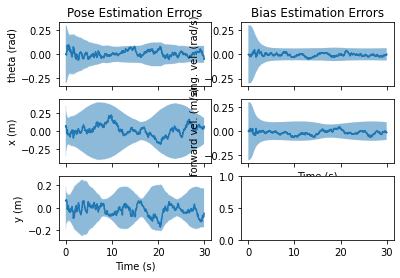

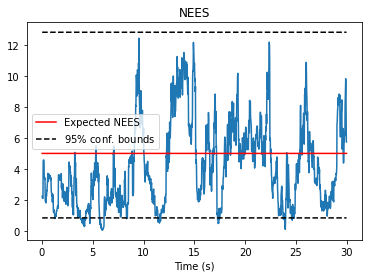

In [53]:
dg = nav.DataGenerator(
    process_model=process_model,                 
    input_func=lambda t, x: np.array([0.5, 0.3, 0.0, 0.0]), 
    input_covariance= Q,                         
    input_freq=50,                                
    meas_model_list=meas_models,                 
    meas_freq_list=[10, 10, 10, 10]              
)

state_data, input_data, meas_data = dg.generate(x, start=0, stop=30, noise=True)

# First, define the filter
kalman_filter = nav.ExtendedKalmanFilter(process_model)
P0 = np.diag([0.1**2, 1**2, 1**2, 0.1**2, 0.1**2])  # Initial covariance
x = nav.StateWithCovariance(x, P0)  # Estimate and covariance in one container

meas_idx = 0
y = meas_data[meas_idx]
estimates = []
for k in range(len(input_data) - 1):
    u = input_data[k]

    # Fuse any measurements that have occurred.
    while y.stamp < input_data[k + 1].stamp and meas_idx < len(meas_data):
        x = kalman_filter.correct(x, y, u)

        # Load the next measurement
        meas_idx += 1
        if meas_idx < len(meas_data):
            y = meas_data[meas_idx]

    # Predict until the next input is available
    dt = input_data[k + 1].stamp - x.state.stamp
    x = kalman_filter.predict(x, u, dt)

    estimates.append(x.copy())


results = nav.GaussianResultList.from_estimates(estimates, state_data)

import matplotlib.pyplot as plt
fig, axs = nav.plot_error(results)
axs[0,0].set_title("Pose Estimation Errors")
axs[0,0].set_ylabel("theta (rad)")
axs[1,0].set_ylabel("x (m)")
axs[2,0].set_ylabel("y (m)")
axs[2,0].set_xlabel("Time (s)")
axs[0, 1].set_title("Bias Estimation Errors")
axs[0, 1].set_ylabel("ang. vel. (rad/s)")
axs[1, 1].set_ylabel("forward vel. (m/s)")
axs[1, 1].set_xlabel("Time (s)")

fig, ax = nav.plot_nees(results)
ax.set_title("NEES")
ax.set_xlabel("Time (s)")
plt.show()

## Inheriting from `CompositeState`

The previous example showed how to use the `CompositeState` class directly, but it's also possible to inherit from it. This is useful if you want to add some extra methods or attributes to the composite state, or if you are going to frequently be using the same composite state. Here's an example of how you would do it:

In [55]:
class WheeledRobotState(nav.CompositeState):
    def __init__(self, pose_values: np.ndarray, bias_values: np.ndarray, stamp: float):
        pose = nav.lib.SE2State(pose_values, stamp=stamp, state_id="pose")
        bias = nav.lib.VectorState(bias_values, stamp=stamp, state_id="bias")
        super().__init__([pose, bias], stamp=stamp)

    # Define any getter that you want for convenience!    
    @property
    def pose(self):
        return self.value[0]

    @property
    def bias(self):
        return self.value[1]

    def copy(self):
        return WheeledRobotState(self.pose.copy(), self.bias.copy())
    
x = WheeledRobotState([0.1, 2.0, 3.0], [0.1, 2.0], stamp = 0.1)
print(x)

WheeledRobotState(stamp=0.1, state_id=None) with substates:
    SE2State(stamp=0.1, state_id=pose, direction=right)
        [[ 0.99500417 -0.09983342  1.84679329]
         [ 0.09983342  0.99500417  3.09491919]
         [ 0.          0.          1.        ]]
    VectorState(stamp=0.1, dof=2, state_id=bias)
        [0.1 2. ]
SE2State(stamp=0.1, state_id=pose, direction=right)
    [[ 0.99500417 -0.09983342  1.84679329]
     [ 0.09983342  0.99500417  3.09491919]
     [ 0.          0.          1.        ]]


This can end up looking a lot cleaner, and is potentially more flexible to work with since you can add methods and attributes to the composite state. For example, because of the getters we defined above, we can access the pose and bias more ergonomically with `x.pose` and `x.bias`.